In [1]:
#⭐ PHASE 1: Dataset Preparation (Requirement #1)
#🎯 Goal:
#Download 10-year historical stock data
#Preprocess
#Do feature engineering
#Save dataset files

#✅ STEP 1— Install libraries
!pip install yfinance pandas numpy scikit-learn xgboost shap lime matplotlib seaborn tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=fd11a264ee1b3074b3d2c87f7bd8eae279a791b7bfd98ec6ccc4a887aa4723bb
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [2]:
#✅ STEP 2 — Import all libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import yfinance as yf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, recall_score, confusion_matrix

import shap
from lime.lime_tabular import LimeTabularExplainer

import xgboost as xgb
import tensorflow as tf
from tensorflow import keras


In [3]:
#✅ STEP 3 — Download dataset
data = yf.download("AAPL", start="2014-01-01", end="2024-01-01")
data.to_csv("raw_stock_data.csv")

data.head()


/tmp/ipython-input-2065429024.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("AAPL", start="2014-01-01", end="2024-01-01")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2014-01-02,17.156704,17.277672,17.122275,17.235799,234684800
2014-01-03,16.779837,17.174378,16.762776,17.148324,392467600
2014-01-06,16.871347,16.960367,16.550936,16.670354,412610800
2014-01-07,16.750685,16.934307,16.684928,16.883439,317209200
2014-01-08,16.856766,16.921901,16.708813,16.712533,258529600


In [4]:
#✅ STEP 4— Feature Engineering
#Cultus requires:
#✔ stationarity checks
#✔ engineered features
#✔ rationale
#create:
#Return_1d
#Return_5d
#Volatility_5d
#Lag1
#Lag5
#Target (price increase after 5 days)
df = data.copy()

df["Return_1d"] = df["Close"].pct_change()
df["Return_5d"] = df["Close"].pct_change(5)
df["Volatility_5d"] = df["Return_1d"].rolling(5).std()

df["Lag1"] = df["Return_1d"].shift(1)
df["Lag5"] = df["Return_1d"].shift(5)

df["Target"] = (df["Close"].shift(-5) > df["Close"]).astype(int)

df = df.dropna()
df.to_csv("processed_financial_dataset.csv", index=False)

df.head()


Price,Close,High,Low,Open,Volume,Return_1d,Return_5d,Volatility_5d,Lag1,Lag5,Target
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,,,,
Date,,,,,,,,,,,
2014-01-10,16.530457,16.774254,16.473694,16.744166,304976000,-0.006673,-0.014862,0.008437,-0.012770,-0.021966,1
2014-01-13,16.616999,16.826986,16.435546,16.436477,378492800,0.005235,-0.015076,0.008383,-0.006673,0.005454,1
2014-01-14,16.947641,16.958187,16.676858,16.694228,332561600,0.019898,0.011758,0.012670,0.005235,-0.007152,1
2014-01-15,17.287907,17.375997,17.111107,17.168800,391638800,0.020077,0.025577,0.015010,0.019898,0.006333,0
2014-01-16,17.191444,17.272090,17.111728,17.211606,229278000,-0.005580,0.033046,0.013085,0.020077,-0.012770,0


In [5]:
#⭐ PHASE 2: Train Two Models (Requirement #2)
#Cultus needs:
#Model 1 → XGBoost
#Model 2 → Neural Network

#✅ STEP 5— Train/Test Split
features = ["Return_1d", "Return_5d", "Volatility_5d", "Lag1", "Lag5"]

X = df[features]
y = df["Target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train.to_csv("X_test_data.csv", index=False)
y_test.to_csv("y_test_data.csv", index=False)


In [6]:
#✅ STEP 6 — Scale Data (only for NN)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [7]:
#⭐ Model 1 — XGBoost
model_xgb = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
model_xgb.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, ...)

In [8]:
#✔ Predictions + Metrics
preds = model_xgb.predict(X_test)
probs = model_xgb.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, preds))
print("AUC:", roc_auc_score(y_test, probs))
print("Recall:", recall_score(y_test, preds))
print(confusion_matrix(y_test, preds))


Accuracy: 0.5338645418326693
AUC: 0.5059637404580153
Recall: 0.7786259541984732
[[ 64 176]
 [ 58 204]]


In [9]:
#⭐ Model 2 — Neural Network (Keras)
model_nn = keras.Sequential([
    keras.layers.Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_nn.fit(X_train_scaled, y_train, epochs=20, batch_size=32, verbose=0)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
#✔ Predictions
nn_probs = model_nn.predict(X_test_scaled).flatten()
nn_preds = (nn_probs > 0.5).astype(int)

print("NN Accuracy:", accuracy_score(y_test, nn_preds))
print("NN AUC:", roc_auc_score(y_test, nn_probs))
print("NN Recall:", recall_score(y_test, nn_preds))


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
NN Accuracy: 0.5258964143426295
NN AUC: 0.5189408396946564
NN Recall: 0.9580152671755725


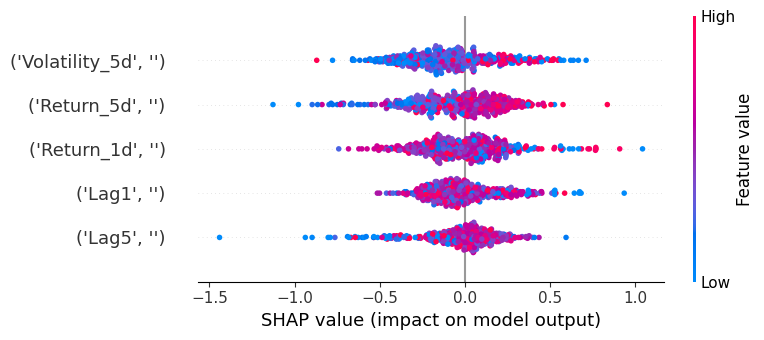

In [11]:
#⭐ PHASE 3: SHAP (Requirement #3)
#Global Summary Plot
explainer = shap.Explainer(model_xgb, X_train)
shap_values = explainer(X_test)

shap.summary_plot(shap_values.values, X_test, show=False)
plt.savefig("shap_summary.png", dpi=300)
plt.show()


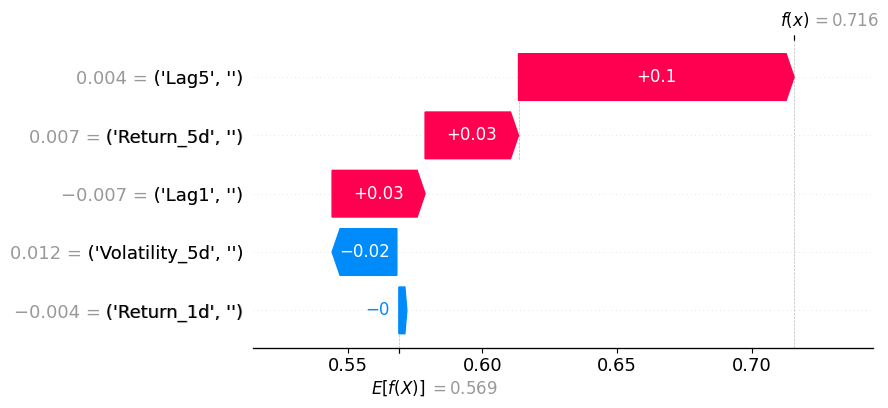

<Figure size 640x480 with 0 Axes>

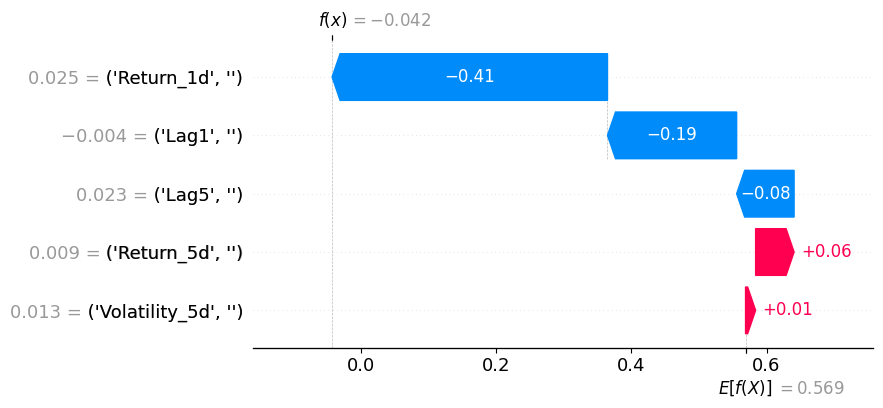

<Figure size 640x480 with 0 Axes>

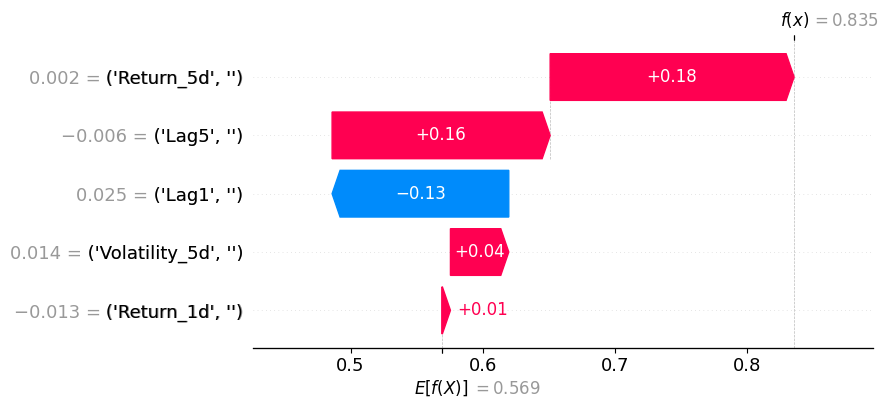

<Figure size 640x480 with 0 Axes>

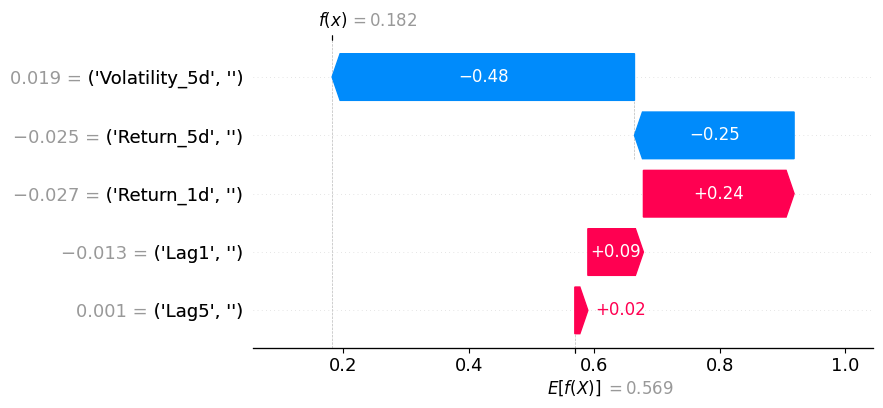

<Figure size 640x480 with 0 Axes>

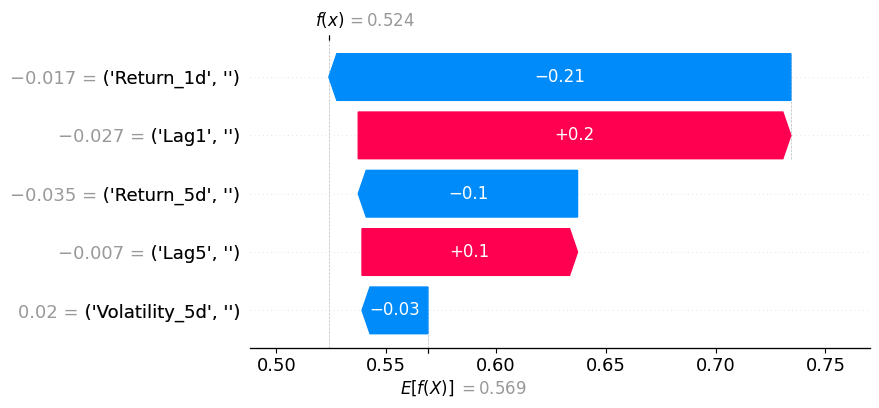

<Figure size 640x480 with 0 Axes>

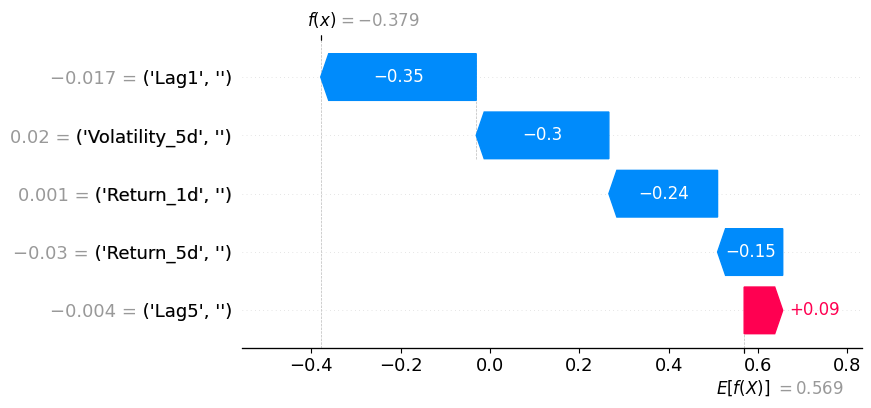

<Figure size 640x480 with 0 Axes>

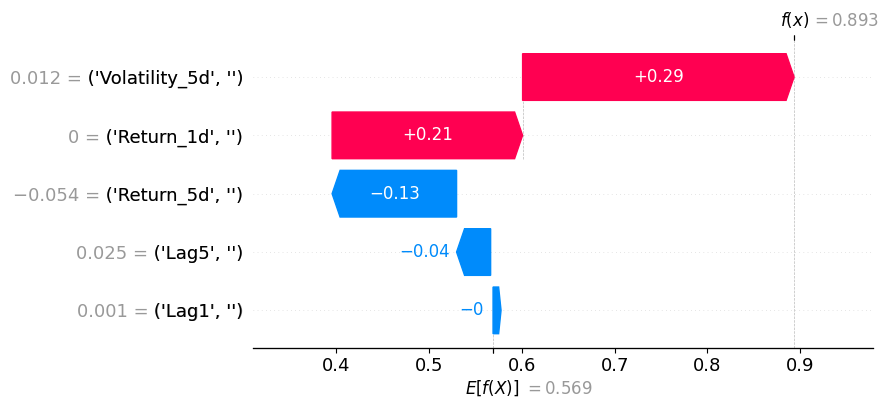

<Figure size 640x480 with 0 Axes>

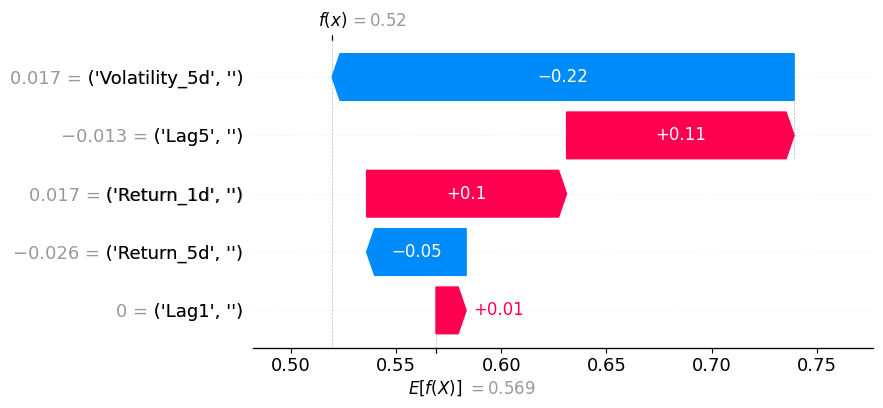

<Figure size 640x480 with 0 Axes>

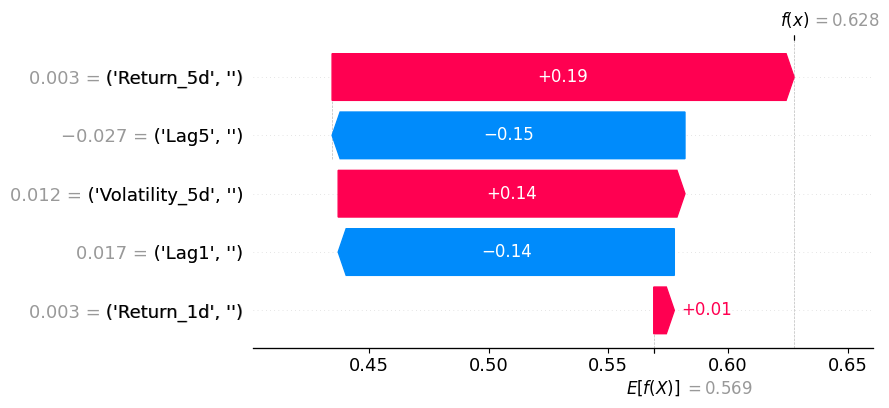

<Figure size 640x480 with 0 Axes>

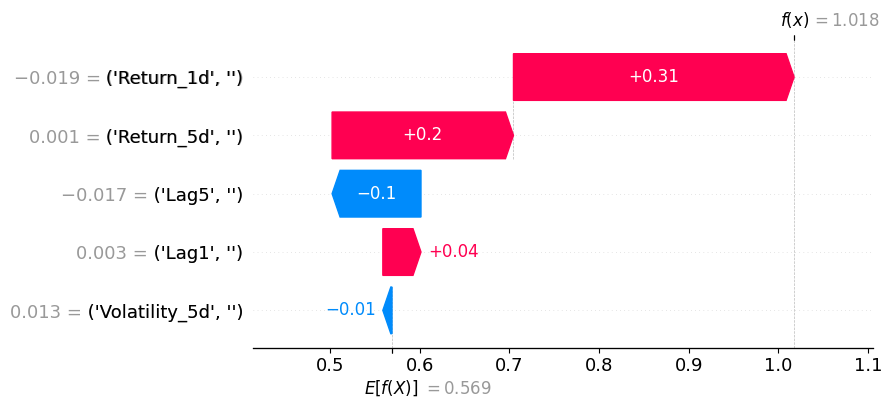

<Figure size 640x480 with 0 Axes>

In [12]:
#10 Local Waterfall Plots
for i in range(10):
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_values.values[i],
            base_values=shap_values.base_values[i],
            data=X_test.iloc[i],
            feature_names=X_test.columns
        )
    )
    plt.savefig(f"shap_local_{i}.png", dpi=300)
    plt.show()


In [13]:
#⭐ PHASE 4: LIME (Requirement #4)
lime_exp = LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=features,
    class_names=["Down","Up"],
    mode='classification'
)

for i in range(10):
    exp = lime_exp.explain_instance(
        X_test.iloc[i].values,
        model_xgb.predict_proba
    )
    exp.save_to_file(f"lime_local_{i}.html")


In [14]:
#⭐ PHASE 5: Comparative Analysis (Requirement #5)
#⭐ PHASE 6: Create GitHub Repo (Requirement #6)
df.to_csv("processed_financial_dataset.csv", index=False)
pd.DataFrame(X_test).to_csv("X_test_data.csv", index=False)
pd.DataFrame(y_test).to_csv("y_test_data.csv", index=False)
